# Modelling V2

## Overview of the Unified Model Architecture

This version of the modelling pipeline represents a significant architectural departure from traditional computer vision pipelines. Instead of treating **feature extraction** and **classification** as separate, sequential steps, this implementation unifies them into a single, end-to-end trainable model within one TensorFlow computational graph.

### Key Architectural Decisions:

1. **Unified Pipeline**: The entire process—from data augmentation through feature extraction to final classification—executes within a single TensorFlow graph. This approach ensures:
   - Automatic differentiation flows seamlessly from output back through all layers
   - GPU memory is used more efficiently
   - The model can be deployed as a single unit without managing multiple components

2. **Transfer Learning with ResNet50**: Rather than using ResNet50 as a standalone feature extractor (which would require saving intermediate features and training a separate classifier), we:
   - Use ResNet50 (pre-trained on ImageNet) as the **backbone** of our model
   - **Freeze** the ResNet50 weights to preserve learned features
   - Append custom **Dense and Dropout layers** on top for our specific classification task
   
   This strategy leverages powerful pre-trained features while allowing task-specific learning in the final layers.

3. **Dynamic Architecture with Hyperparameter Optimization**: The model architecture itself (number of layers, units per layer, dropout rates) is **not fixed**. Instead, we use **Optuna** to systematically search for the optimal configuration, treating the architecture as part of the hyperparameter space.

This integrated approach simplifies deployment, improves training efficiency, and creates a more maintainable codebase compared to multi-stage pipelines.

The first step involves reading the CSV that contains all of the images that will be used for model creation.

In [13]:
import cv2
import pandas as pd

final_data_path = open("step1.txt", "r")
final_data_pre = pd.read_csv(final_data_path.read().strip())

In [14]:
final_data_pre

id            class_name  \
0     452f2473f3dd5817395dcaa16b58ab6e.png      banana_day1_self   
1     2da7e04b024ef07fd40e4f84213d6ca7.png      banana_day1_self   
2     708f00dd2a7c25d75680d18299d0254d.png      banana_day1_self   
3     866d7784b51be1f26a96af4c99e73448.png      banana_day1_self   
4     2e4fbf3ef0199cd4f664155171dbb849.png      banana_day1_self   
...                                    ...                   ...   
3850  36d731da560f32647b0b24173553e717.png  banana_unripe_google   
3851  8017d535e8953dd8385f2bd274b86048.png  banana_unripe_google   
3852  d2db0415723f10fc0543f9661202c5b5.png  banana_unripe_google   
3853  dc68cbab2497a85acdab0f2e010085d6.png  banana_unripe_google   
3854  d20187f50d895a40f5517b7940ee8df0.png  banana_unripe_google   

                                              file_path resolution  
0     /home/fadhlan/Normal2/DeepLearningRepo/steps/v...   720x1280  
1     /home/fadhlan/Normal2/DeepLearningRepo/steps/v...   720x1280  
2     /home/fadhlan/Normal2/DeepLearningRepo/steps/v...   720x1280  
3     /home/fadhlan/Normal2/DeepLearningRepo/steps/v...   720x1280  
4     /home/fadhlan/Normal2/DeepLearningRepo/steps/v...   1280x720  
...                                                 ...        ...  
3850  /home/fadhlan/Normal2/DeepLearningRepo/steps/v...    300x168  
3851  /home/fadhlan/Normal2/DeepLearningRepo/steps/v...    225x225  
3852  /home/fadhlan/Normal2/DeepLearningRepo/steps/v...    291x173  
3853  /home/fadhlan/Normal2/DeepLearningRepo/steps/v...    225x225  
3854  /home/fadhlan/Normal2/DeepLearningRepo/steps/v...    390x280  

[3855 rows x 4 columns]

The DataFrame format is generated by the createDerivation.py script, and the images were converted by the Paralells sub program.

---

## Data Preparation Pipeline

The following sections establish the data preparation workflow, which is crucial for ensuring robust model training and unbiased evaluation.

### Creating Train/Test/Validation Splits

The data is split into three distinct sets to enable proper model development and unbiased evaluation:

- **Validation Set (15%)**: Held out completely until final evaluation. This set is never seen during model development or hyperparameter tuning, ensuring an unbiased assessment of model performance.

- **Training Set (68%)**: Used to train model weights. This is 80% of the remaining 85% after validation split.

- **Testing Set (17%)**: Used by Optuna during hyperparameter search. This is 20% of the remaining 85% after validation split.

**Why this split?**
- The separation prevents **data leakage** and **overfitting** to the test set during hyperparameter optimization
- The validation set serves as a true "hold-out" set, simulating real-world performance on completely unseen data
- Stratified splitting ensures class balance is maintained across all three sets, which is critical for imbalanced datasets

In [15]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
import pandas as pd
import numpy as np
import optuna

def load_image(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    return img, label

def create_train_test_val_dfs(final_data_pre):
    
    label_processor = tf.keras.layers.StringLookup(
        output_mode='int', 
        vocabulary=final_data_pre['class_name'].unique(),
        num_oov_indices=0,
        mask_token=None 
    )
    number_of_classes = len(final_data_pre['class_name'].unique())
    train_and_tuning_df, val_df = train_test_split(
        final_data_pre, 
        test_size=0.15, 
        random_state=42, 
        stratify=final_data_pre['class_name']
    )
    train_df, test_df = train_test_split(
        train_and_tuning_df, 
        test_size=0.2, 
        random_state=42, 
        stratify=train_and_tuning_df['class_name']
    )
    print(f"Train (Weights):    {len(train_df)}")
    print(f"Test  (Optuna):     {len(test_df)}")
    print(f"Val   (Final Eval): {len(val_df)}")
    return {
        "number_of_classes": number_of_classes,
        "label_processor": label_processor,
        "train_df": train_df,
        "test_df": test_df,
        "val_df": val_df
    }

**Implementation Details:**
- The `StringLookup` layer encodes class names to integer labels, which is more efficient than string comparisons
- Stratification ensures each split maintains the original class distribution
- Random state (42) ensures reproducibility across runs

The splitting ratio is 15% of the initial data is validation data, then of the remanining 85%, 80% is used for training and 20% is used for testing.    

### Creating TensorFlow Datasets with Data Augmentation

This function transforms the pandas DataFrames into optimized `tf.data.Dataset` objects, which are TensorFlow's high-performance data pipeline API. A critical component here is **data augmentation**, applied only to the training set.

**Why Data Augmentation?**

Deep learning models, especially when fine-tuning, are prone to **overfitting**—memorizing training examples rather than learning generalizable patterns. Data augmentation artificially expands the training set by applying random transformations to images, forcing the model to learn robust, invariant features.

**Augmentation Strategies Applied:**
- **Random Flips**: Horizontal and vertical flips teach the model that ripeness is independent of orientation
- **Random Rotation** (±20%): Accounts for different camera angles during image capture
- **Random Zoom** (±20%): Simulates varying distances from the subject
- **Random Translation** (10%): Handles off-center subjects
- **Random Contrast & Brightness** (±20%): Compensates for different lighting conditions

**Critical Design Choice:** Augmentation is applied **within the TensorFlow graph** (not as a preprocessing step), meaning:
- Augmentations are generated on-the-fly during training (each epoch sees different variations)
- No need to store augmented images on disk
- Augmentation happens on the GPU, leveraging hardware acceleration

**Why Only Training Data?**
Test and validation sets should represent real-world data without artificial modifications, ensuring our performance metrics reflect actual model capability.

In [16]:
from tensorflow.keras import layers, Model, regularizers

def create_dses(input):
    # --- Configuration ---
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2), # Rotate +/- 20%
        layers.RandomZoom(0.2),     # Zoom in/out 20%
        layers.RandomTranslation(0.1, 0.1), # Shift image
        layers.RandomContrast(0.2), # Adjust contrast
        layers.RandomBrightness(0.2)
    ])

    def load_image(filepath, label):
        img = tf.io.read_file(filepath)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [224, 224])
        return img, label

    def create_dataset(df, is_training=True, batch_size=32):
        # Create source dataset
        ds = tf.data.Dataset.from_tensor_slices((df['file_path'].values, df['class_name'].values))
        ds = ds.map(lambda x, y: (x, input["label_processor"](y)))
        ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
        if is_training:
            ds = ds.shuffle(buffer_size=1000)
            # We wrap augmentation in a lambda to ensure it runs correctly in graph mode
            ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                        num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return ds

    # Create the specific datasets
    train_ds = create_dataset(input["train_df"], is_training=True)
    test_ds  = create_dataset(input["test_df"], is_training=False)
    val_ds   = create_dataset(input["val_df"], is_training=False)
    return {
        "train_ds": train_ds,
        "number_of_classes": input["number_of_classes"],
        "test_ds": test_ds,
        "val_ds": val_ds
    }

**Performance Optimizations:**
- `.prefetch(AUTOTUNE)`: Prepares the next batch while the current batch is being processed, minimizing GPU idle time
- `.map(..., num_parallel_calls=AUTOTUNE)`: Parallelizes data loading and preprocessing across CPU cores
- `.shuffle(buffer_size=1000)`: Randomizes training order to prevent the model from learning sequence-based patterns

The code block in this case only defines a function and doesnt actually do it to increase the modularity of the pipeline.

---

## Hyperparameter Optimization with Optuna

This section implements **automated hyperparameter tuning** using Optuna, a state-of-the-art optimization framework. Rather than manually experimenting with different configurations, Optuna systematically explores the hyperparameter space to find optimal settings.

### What is Being Optimized?

The `train_model` function uses Optuna to optimize multiple hyperparameters simultaneously:

1. **Learning Rate** (1e-5 to 1e-3, log scale): Controls how aggressively the model updates weights. Log scale is appropriate because learning rates often work best at different orders of magnitude (e.g., 0.0001 vs 0.001).

2. **Number of Layers** (1 to 10): Determines the depth of the custom classifier head added on top of ResNet50.

3. **Units per Layer** (32 to 512, step of 32): Controls the width of each layer. Each layer can have a different number of units, allowing asymmetric architectures.

4. **Dropout Rate** (0.1 to 0.5): The probability of randomly dropping neurons during training, a regularization technique to prevent overfitting.

5. **Training Epochs** (5 to 20): How many complete passes through the training data.

### How Does Optuna Work?

- **Trial-based Search**: Each "trial" represents one complete training run with a specific hyperparameter configuration
- **Tree-structured Parzen Estimator (TPE)**: Optuna's default algorithm learns from previous trials to suggest promising configurations, making the search more efficient than random search
- **Pruning**: The `TFKerasPruningCallback` stops unpromising trials early (e.g., if validation accuracy is poor after a few epochs), saving computational resources
- **Persistent Storage**: Results are stored in a SQLite database, allowing you to resume optimization across sessions or analyze results later

### Why This Approach?

Manual hyperparameter tuning is time-consuming and often misses optimal configurations. Optuna's intelligent search can explore hundreds of configurations efficiently, often finding better solutions than human intuition alone.

In [17]:
%run modeldef4.py
from sklearn.metrics import f1_score, precision_score, recall_score

def train_model(train_ds, test_ds, number_of_classes, model_name, number_of_trials):
    def objective(trial):
        # 1. Suggest Hyperparameters
        # Log scale is good for learning rates
        lr = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True) 
        
        # A. How many layers? (e.g., between 1 and 10)
        n_layers = trial.suggest_int('n_layers', 1, 10)
    
        # B. Define units for each layer dynamically
        layer_configs = []
        for i in range(n_layers):
            # We create a unique hyperparameter for each layer: "units_layer_0", "units_layer_1", etc.
            units = trial.suggest_int(f'units_layer_{i}', 32, 512, step=32)
            layer_configs.append(units)
        
        # Suggest dropout
        dropout = trial.suggest_float('dropout', 0.1, 0.5)
        epochs = trial.suggest_int("epochs", 5,20, step=1)
        
        # build the model
        model = DynamicResNetClassifier(
            num_classes=number_of_classes,
            layer_configs=layer_configs, # Pass the generated list
            dropout_rate=dropout
        )
        
        # compile
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )
        
        # 4. Train with Pruning
        # The PruningCallback will stop unpromising trials early to save time
        history = model.fit(
            train_ds,
            validation_data=test_ds,
            epochs=epochs, # Short epochs for tuning (increase for final training)
            verbose=0, # Keep output clean
            callbacks=[optuna.integration.TFKerasPruningCallback(trial, 'val_accuracy')]
        )

        # --- NEW CODE: Calculate Metrics for Intermediate Models ---
        # We manually iterate over the test_ds to get predictions vs true labels
        y_true_vals = []
        y_pred_vals = []
        for images, labels in test_ds:
            logits = model(images, training=False)
            preds = tf.argmax(logits, axis=1)
            y_true_vals.extend(labels.numpy())
            y_pred_vals.extend(preds.numpy())
        
        # Calculate Macro metrics (treats all classes equally, good for imbalance)
        val_f1 = f1_score(y_true_vals, y_pred_vals, average='macro', zero_division=0)
        val_prec = precision_score(y_true_vals, y_pred_vals, average='macro', zero_division=0)
        val_rec = recall_score(y_true_vals, y_pred_vals, average='macro', zero_division=0)

        # Print metrics for this trial
        print(f"Trial {trial.number}: Val Acc: {history.history['val_accuracy'][-1]:.4f} | F1: {val_f1:.4f} | Prec: {val_prec:.4f} | Rec: {val_rec:.4f}")
        # -----------------------------------------------------------

        # Log train accuracy, loss, and validation accuracy and loss
        trial.set_user_attr("train_accuracy", history.history['accuracy'][-1])
        trial.set_user_attr("train_loss", history.history['loss'][-1])
        trial.set_user_attr("val_accuracy", history.history['val_accuracy'][-1])
        trial.set_user_attr("val_loss", history.history['val_loss'][-1])
        trial.set_user_attr("val_f1", val_f1)
        trial.set_user_attr("val_prec", val_prec)
        trial.set_user_attr("val_rec", val_rec)

        # Return the best validation accuracy of this trial
        return max(history.history['val_accuracy'])

    storage_name = "sqlite:///{}.db".format(model_name)

    study = optuna.create_study(
        study_name=model_name,
        storage=storage_name,  
        direction='maximize',
        load_if_exists=True    
    )

    print("Starting Hyperparameter Tuning for " + model_name + "....")
    study.optimize(objective, n_trials=number_of_trials)

    print("Best trial:")
    trial = study.best_trial

    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    return study

**Model Architecture Note:**
The `DynamicResNetClassifier` (defined in `modeldef4.py`) creates a model with:
- **Frozen ResNet50 backbone**: Pre-trained weights are not updated, serving as a fixed feature extractor
- **Custom classifier head**: Variable number of Dense layers with configurable units and dropout
- **Sparse Categorical Crossentropy loss**: Appropriate for multi-class classification with integer labels

**Dynamic Architecture Explained:**

The model's architecture is **not hardcoded**. Instead, it's defined programmatically based on Optuna's suggestions:
- Each trial can have a different number of layers (1-10)
- Each layer can have a different number of units (32-512)
- This creates an enormous search space (thousands of possible architectures)

For example, one trial might create:
```
ResNet50 → Dense(256) → Dropout(0.3) → Dense(128) → Dropout(0.3) → Output
```

While another might create:
```
ResNet50 → Dense(64) → Dropout(0.2) → Output
```

Optuna learns which architectural patterns work best for our specific data.

---

## Final Model Training and Evaluation

After Optuna identifies the best hyperparameters, we train a final model and evaluate it on the **held-out validation set**. This is the critical moment where we assess true model performance on completely unseen data.

### The Evaluation Protocol

The function `train_final_and_evaluate` implements a rigorous evaluation methodology:

1. **Rebuild Model**: Construct a new model using the best hyperparameters found by Optuna
2. **Extended Training**: Train for `best_epochs + 5` to ensure the model fully converges with optimal settings
3. **Hold-out Evaluation**: Evaluate on `val_ds` (the validation set that was never touched during development)

**Why This Matters:**

The validation set accuracy is the **only unbiased estimate** of how the model will perform on new, real-world data. Any metrics computed on the training or test sets may be optimistically biased because those datasets influenced model development (either directly through weight updates or indirectly through hyperparameter selection).

### Visualization of Predictions

The visualization functions help assess model behavior qualitatively:
- **Correct Predictions Grid**: Shows what the model recognizes well
- **Incorrect Predictions Grid**: Reveals failure modes and potential areas for improvement

This qualitative analysis complements quantitative metrics, helping identify systematic errors (e.g., confusing specific ripeness stages).

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report

def train_final_and_evaluate(study, train_ds, test_ds, val_ds, number_of_classes):
    best_params = study.best_trial.params
    print("Best Parameters Found:")
    print(best_params)
    best_layers = []
    for i in range(study.best_trial.params['n_layers']):
        best_layers.append(study.best_trial.params[f'units_layer_{i}'])

    # train the final BEST model with the BEST parameters
    final_model = DynamicResNetClassifier(
        num_classes=number_of_classes,
        layer_configs=best_layers, # Pass the generated list
        dropout_rate=best_params['dropout']
    )

    # Compile model with final learning rate
    final_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    final_model.build(input_shape=(None, 224, 224, 3))
    # Final Training Run
    print("\nStarting Final Training...")
    history = final_model.fit(
        train_ds,
        validation_data=test_ds, 
        epochs=best_params['epochs'] + 5, # minor fudge factor for epochs
        verbose=1
    )


    # The Moment of Truth (Evaluation)
    # This is the ONLY time 'val_ds' is touched.
    print("\nRunning Final Evaluation on Hold-out Set (val_ds)...")
    test_loss, test_accuracy = final_model.evaluate(val_ds)

    print("="*40)
    print(f"FINAL UNBIASED ACCURACY: {test_accuracy * 100:.2f}%")
    print("="*40)

    # --- NEW CODE: Classification Report for Final Model ---
    print("\nGenerating Detailed Classification Report...")
    y_true_vals = []
    y_pred_vals = []
    
    # Iterate over the dataset to get all predictions
    for images, labels in val_ds:
        logits = final_model(images, training=False)
        preds = tf.argmax(logits, axis=1)
        y_true_vals.extend(labels.numpy())
        y_pred_vals.extend(preds.numpy())
    
    # Print the full report
    # target_names argument is optional, but helps if you have class names list available
    print(classification_report(y_true_vals, y_pred_vals, digits=4))
    print("="*40)
    # -----------------------------------------------------

    return {
        "final_model": final_model,
        "history": history
    }

def visualize_predictions(dataset, model, label_processor, grid_rows=2, grid_cols=4):
    num_samples = grid_rows * grid_cols
    class_names = label_processor.get_vocabulary()
    correct_batch = {'imgs': [], 'true': [], 'pred': []}
    incorrect_batch = {'imgs': [], 'true': [], 'pred': []}

    print(f"Collecting {num_samples} correct and {num_samples} incorrect examples...")
    
    for images, labels in dataset:
        # Stop if we have enough of both
        if (len(correct_batch['imgs']) >= num_samples and 
            len(incorrect_batch['imgs']) >= num_samples):
            break

        logits = model(images, training=False)
        preds = tf.argmax(logits, axis=1)
        
        images_np = images.numpy()
        labels_np = labels.numpy()
        preds_np = preds.numpy()
        
        for i in range(len(images_np)):
            if (len(correct_batch['imgs']) >= num_samples and 
                len(incorrect_batch['imgs']) >= num_samples):
                break
            
            true_idx = labels_np[i]
            pred_idx = preds_np[i]
            is_correct = (true_idx == pred_idx)
            
            target_dict = correct_batch if is_correct else incorrect_batch
            
            if len(target_dict['imgs']) < num_samples:
                target_dict['imgs'].append(images_np[i])
                target_dict['true'].append(class_names[true_idx])
                target_dict['pred'].append(class_names[pred_idx])

    # 2. Grid Plotting Logic
    def plot_grid(data_dict, title, color_code):
        count = len(data_dict['imgs'])
        if count == 0:
            print(f"No {title.lower()} predictions found.")
            return
        
        fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(3 * grid_cols, 3.5 * grid_rows))
        fig.suptitle(f"{title} Predictions", fontsize=20, color=color_code, weight='bold', y=1.02)
        axes_flat = axes.flatten() if count > 1 else [axes]
        
        for i in range(num_samples):
            ax = axes_flat[i]
            
            # if somehow the model is 100% accurate
            if i >= count:
                ax.axis('off')
                continue
            
            # Plot Image
            img = data_dict['imgs'][i].astype("uint8")
            ax.imshow(img)
            ax.axis("off")
            true_lab = data_dict['true'][i]
            pred_lab = data_dict['pred'][i]
            label_text = f"True: {true_lab}\nPred: {pred_lab}"
            ax.set_title(label_text, color='black', fontsize=11, pad=10)
            border_color = color_code
            plt.setp(ax.spines.values(), color=border_color, linewidth=2)

        plt.tight_layout()
        plt.show()

    # 3. Generate the two grids
    plot_grid(correct_batch, "Correct", "green")
    print("\n" + "="*50 + "\n")
    plot_grid(incorrect_batch, "Incorrect", "red")

**Interpretation Notes:**
- High validation accuracy suggests the model generalizes well
- Large gaps between training and validation accuracy indicate overfitting
- Examining misclassified images can reveal whether errors are due to:
  - Ambiguous images (even humans would struggle)
  - Systematic biases (e.g., always confusing two specific classes)
  - Insufficient training data for certain classes

---

# Model Training Experiments

The following sections train and evaluate three different models to investigate an important research question: **Should we build specialized models for each fruit type, or can a single unified model handle all classes?**

This is a common trade-off in machine learning:
- **Specialized Models**: May achieve higher accuracy for their specific domain but require maintaining multiple models
- **Unified Models**: Simpler deployment and may benefit from cross-domain learning, but might sacrifice some per-class accuracy

We'll train:
1. **Avocado-Only Model**: Trained exclusively on avocado ripeness stages
2. **Banana-Only Model**: Trained exclusively on banana ripeness stages  
3. **Combined Model**: Trained on both fruits simultaneously

By comparing their performance, we can make an informed decision about the best deployment strategy.

## Avocado Testing & Evaluation

In [19]:

# Train avocado only model
avocado_only = final_data_pre[final_data_pre["class_name"].str.contains("avocado")]
step1avc = create_train_test_val_dfs(avocado_only)
step2avc = create_dses(step1avc)

I0000 00:00:1766327826.748661   60867 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6136 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Train (Weights):    2368
Test  (Optuna):     592
Val   (Final Eval): 523


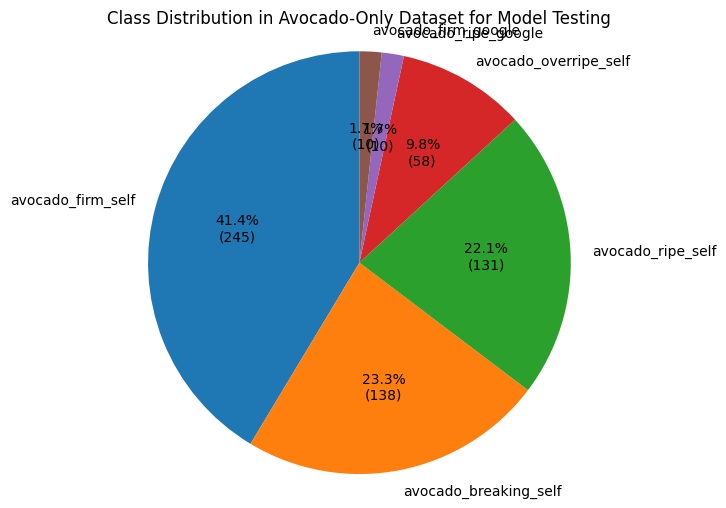

In [17]:
# Show the distribution of the dataset
avocado_vis = step1avc["test_df"]["class_name"].value_counts()
def make_autopct(values):
    def my_autopct(pct):
        total = int(values.sum())
        val = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({val})'
    return my_autopct

plt.figure(figsize=(6, 6))
avocado_vis.plot(
    kind='pie',
    autopct=make_autopct(avocado_vis),
    startangle=90,
    legend=False
)
plt.title('Class Distribution in Avocado-Only Dataset for Model Testing')
plt.ylabel('')
plt.axis('equal')  # keep pie circular
plt.show()

### Data Preparation

We filter the dataset to include only avocado samples, then apply our standard data preparation pipeline:
1. Create stratified train/test/validation splits
2. Build TensorFlow datasets with augmentation

In [21]:
study_avc = train_model(step2avc["train_ds"],step2avc["test_ds"], step2avc["number_of_classes"], "avocado_only", 15)

[I 2025-12-21 14:38:30,785] A new study created in RDB with name: avocado_only


Starting Hyperparameter Tuning for avocado_only....


2025-12-21 14:38:38.654775: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:38:38.654809: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:38:38.654827: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:38:39.285832: I external/l

Trial 0: Val Acc: 0.7753 | F1: 0.5090 | Prec: 0.5385 | Rec: 0.5314


2025-12-21 14:40:06.599487: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:40:06.599518: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:40:06.599570: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:40:06.599635: I external/l

Trial 1: Val Acc: 0.7939 | F1: 0.4205 | Prec: 0.3930 | Rec: 0.4635


2025-12-21 14:41:44.842585: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:41:44.842618: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:41:44.842636: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:41:44.842812: I external/l

KeyboardInterrupt: 

### Hyperparameter Optimization

Running 15 Optuna trials to find the best architecture and hyperparameters for avocado classification. Each trial trains a model with different configurations and the best-performing one is selected based on test set accuracy.

In [8]:
storage_name = "sqlite:///{}.db".format("avocado_only")

study = optuna.create_study(
    study_name="avocado_only",
    storage=storage_name,  
    direction='maximize',
    load_if_exists=True    
)
study_avc = study

[I 2025-12-20 02:02:33,199] Using an existing study with name 'avocado_only' instead of creating a new one.


### Loading Previous Study (Optional)

This cell loads a previously completed Optuna study from the database. Useful for resuming analysis without re-running expensive optimization.

In [9]:
avc_results = train_final_and_evaluate(study_avc, step2avc["train_ds"],step2avc["test_ds"], step2avc["val_ds"], step2avc["number_of_classes"])


Best Parameters Found:
{'learning_rate': 0.00022931099247714063, 'n_layers': 4, 'units_layer_0': 352, 'units_layer_1': 224, 'units_layer_2': 96, 'units_layer_3': 160, 'dropout': 0.10486705577726162, 'epochs': 20}

Starting Final Training...
Epoch 1/25


/root/miniconda3/envs/DeepLearning/lib/python3.12/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'dynamic_res_net_classifier', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
2025-12-20 02:02:43.832759: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ff4d8013660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-20 02:02:43.832783: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-12-20 02:02:44.150640: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-

 3/74 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.1736 - loss: 1.7656 

I0000 00:00:1766196176.253883   15941 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4739 - loss: 1.2601

2025-12-20 02:03:04.480480: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-20 02:03:04.480520: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-20 02:03:05.225954: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1751', 4 bytes spill stores, 4 bytes spill loads

2025-12-20 02:03:09.229723: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : R

74/74 ━━━━━━━━━━━━━━━━━━━━ 34s 209ms/step - accuracy: 0.6052 - loss: 0.9881 - val_accuracy: 0.8243 - val_loss: 0.5005
Epoch 2/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.8108 - loss: 0.4694 - val_accuracy: 0.8801 - val_loss: 0.2905
Epoch 3/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.8733 - loss: 0.3224 - val_accuracy: 0.9223 - val_loss: 0.2031
Epoch 4/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.8923 - loss: 0.2581 - val_accuracy: 0.9240 - val_loss: 0.1948
Epoch 5/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.9172 - loss: 0.1996 - val_accuracy: 0.9375 - val_loss: 0.1591
Epoch 6/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.9109 - loss: 0.2185 - val_accuracy: 0.9476 - val_loss: 0.1494
Epoch 7/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.9261 - loss: 0.1842 - val_accuracy: 0.9257 - val_loss: 0.1567
Epoch 8/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.9295 - loss: 0.1712 - val_accuracy: 0.9426 - val

2025-12-20 02:06:42.668959: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1744', 4 bytes spill stores, 4 bytes spill loads



17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 260ms/step - accuracy: 0.9503 - loss: 0.1102
FINAL UNBIASED ACCURACY: 95.03%


### Final Training and Validation

Training the final avocado model with optimal hyperparameters and evaluating on the held-out validation set. The accuracy reported here is the unbiased performance estimate.

In [ ]:
visualize_predictions(
    step2avc["val_ds"],
    avc_results["final_model"],
    step1avc["label_processor"],
    grid_rows=3,  # Adjust rows here
    grid_cols=4   # Adjust columns here
)

### Qualitative Analysis

Visualizing correct and incorrect predictions to understand model behavior. Look for patterns in failures—are certain ripeness stages consistently confused?

## Banana Testing & Evaluation

In [9]:

# Train banana only model
banana_only = final_data_pre[final_data_pre["class_name"].str.contains("banana")]
step1banan = create_train_test_val_dfs(banana_only)
step2banan = create_dses(step1banan)

Train (Weights):    252
Test  (Optuna):     64
Val   (Final Eval): 56


### Data Preparation

Filtering dataset to banana samples only and preparing train/test/validation splits.

In [10]:
study_banana = train_model(step2banan["train_ds"],step2banan["test_ds"], step2banan["number_of_classes"], "banana_only", 15)

[I 2025-12-21 14:25:29,649] A new study created in RDB with name: banana_only


Starting Hyperparameter Tuning for banana_only....


2025-12-21 14:25:37.997296: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:25:37.997324: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:25:37.997472: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:25:37.997492: I external/l

Trial 0: Val Acc: 0.6875 | F1: 0.6356 | Prec: 0.6426 | Rec: 0.6512


2025-12-21 14:26:26.148500: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:26:26.148530: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:26:26.683490: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5951', 12 bytes spill stores, 12 bytes spill loads

2025-12-21 14:26:27.592213: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

Trial 1: Val Acc: 0.5469 | F1: 0.4935 | Prec: 0.4783 | Rec: 0.5340


2025-12-21 14:26:52.268667: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:26:52.268774: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:26:52.268803: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:26:52.268873: I external/l

Trial 2: Val Acc: 0.3438 | F1: 0.1943 | Prec: 0.1880 | Rec: 0.2840


2025-12-21 14:27:45.346862: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:27:45.346916: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:27:45.346988: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:27:45.347003: I external/l

Trial 3: Val Acc: 0.1562 | F1: 0.0635 | Prec: 0.0838 | Rec: 0.1373


[I 2025-12-21 14:28:24,413] Trial 3 finished with value: 0.15625 and parameters: {'learning_rate': 2.676640249223144e-05, 'n_layers': 9, 'units_layer_0': 416, 'units_layer_1': 160, 'units_layer_2': 32, 'units_layer_3': 128, 'units_layer_4': 416, 'units_layer_5': 288, 'units_layer_6': 96, 'units_layer_7': 32, 'units_layer_8': 128, 'dropout': 0.22374437641321832, 'epochs': 13}. Best is trial 0 with value: 0.6875.
2025-12-21 14:28:34.439391: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:28:34.439443: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Wo

Trial 4: Val Acc: 0.1875 | F1: 0.1036 | Prec: 0.1004 | Rec: 0.1574


2025-12-21 14:29:29.839711: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:29:29.839759: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:29:29.839906: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:29:29.839920: I external/l

Trial 8: Val Acc: 0.7188 | F1: 0.7108 | Prec: 0.7475 | Rec: 0.7160


2025-12-21 14:32:06.873840: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:32:06.873870: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 14:32:08.020647: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5972', 520 bytes spill stores, 520 bytes spill loads

2025-12-21 14:32:08.235982: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning

KeyboardInterrupt: 

### Hyperparameter Optimization

Running 15 Optuna trials for banana-specific model optimization.

In [11]:
storage_name = "sqlite:///{}.db".format("banana_only")

study = optuna.create_study(
    study_name="banana_only",
    storage=storage_name,  
    direction='maximize',
    load_if_exists=True    
)
study_banana = study

[I 2025-12-20 02:06:56,809] Using an existing study with name 'banana_only' instead of creating a new one.


### Loading Previous Study (Optional)

In [12]:
banana_results = train_final_and_evaluate(study_banana, step2banan["train_ds"],step2banan["test_ds"], step2banan["val_ds"], step2banan["number_of_classes"])

Best Parameters Found:
{'learning_rate': 0.00039498193752788647, 'n_layers': 4, 'units_layer_0': 480, 'units_layer_1': 352, 'units_layer_2': 512, 'units_layer_3': 352, 'dropout': 0.14898599726023518, 'epochs': 9}

Starting Final Training...
Epoch 1/14


/root/miniconda3/envs/DeepLearning/lib/python3.12/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'dynamic_res_net_classifier_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
2025-12-20 02:07:06.057591: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-20 02:07:06.057622: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contai

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.1121 - loss: 2.3026

2025-12-20 02:07:15.382414: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6192', 56 bytes spill stores, 56 bytes spill loads

2025-12-20 02:07:15.746728: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6396', 80 bytes spill stores, 80 bytes spill loads

2025-12-20 02:07:15.804627: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6739', 8 bytes spill stores, 8 bytes spill loads



8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1169 - loss: 2.2879  

2025-12-20 02:07:22.740992: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1758', 172 bytes spill stores, 172 bytes spill loads



8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.1508 - loss: 2.1851 - val_accuracy: 0.2969 - val_loss: 1.8796
Epoch 2/14
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.3770 - loss: 1.8243 - val_accuracy: 0.4375 - val_loss: 1.5679
Epoch 3/14
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.4325 - loss: 1.5198 - val_accuracy: 0.4844 - val_loss: 1.2467
Epoch 4/14
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.4484 - loss: 1.2611 - val_accuracy: 0.5469 - val_loss: 1.0895
Epoch 5/14
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.5317 - loss: 1.0503 - val_accuracy: 0.6406 - val_loss: 0.9291
Epoch 6/14
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.5675 - loss: 1.0186 - val_accuracy: 0.7031 - val_loss: 0.7949
Epoch 7/14
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.6310 - loss: 0.9135 - val_accuracy: 0.7031 - val_loss: 0.8147
Epoch 8/14
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.6468 - loss: 0.7912 - val_accuracy: 0.7031 - val_loss: 0.7020
Epoch

2025-12-20 02:07:40.724326: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1730', 56 bytes spill stores, 56 bytes spill loads

2025-12-20 02:07:40.826582: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1758', 168 bytes spill stores, 168 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7679 - loss: 0.5251  
FINAL UNBIASED ACCURACY: 76.79%


### Final Training and Validation

Training and evaluating the banana-only model on held-out validation data.

In [ ]:
visualize_predictions(
    step2banan["val_ds"],
    banana_results["final_model"],
    step1banan["label_processor"],
    grid_rows=3,  # Adjust rows here
    grid_cols=4   # Adjust columns here
)

### Qualitative Analysis

Examining banana model predictions to identify strengths and weaknesses.

## Combined Model Testing & Evaluation

In [ ]:

# Train banana only model
all_in_one = final_data_pre
step1aio = create_train_test_val_dfs(all_in_one)
step2aio = create_dses(step1aio)

Train (Weights):    2620
Test  (Optuna):     656
Val   (Final Eval): 579


### Data Preparation

Using the complete dataset with all fruit types and ripeness stages.

In [ ]:
study_aio = train_model(step2aio["train_ds"],step2aio["test_ds"], step2aio["number_of_classes"], "all_in_one", 15)

[I 2025-12-19 11:16:14,982] A new study created in RDB with name: all_in_one


Starting Hyperparameter Tuning for all_in_one....


2025-12-19 11:16:27.967815: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-19 11:16:27.967845: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-19 11:16:27.967861: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-19 11:16:27.967876: I external/l

Best trial:
  Value: 0.9390243887901306
  Params: 
    learning_rate: 0.0009228881754061818
    n_layers: 1
    units_layer_0: 288
    dropout: 0.26184288119904275
    epochs: 20


### Hyperparameter Optimization

Running Optuna trials on the combined dataset. Note: This model has more classes to distinguish, which may require different architecture choices than specialized models.

In [17]:
storage_name = "sqlite:///{}.db".format("all_in_one")

study = optuna.create_study(
    study_name="all_in_one",
    storage=storage_name,  
    direction='maximize',
    load_if_exists=True    
)
study_aio = study

[I 2025-12-19 15:43:14,071] Using an existing study with name 'all_in_one' instead of creating a new one.


### Loading Previous Study (Optional)

In [18]:
aio_results = train_final_and_evaluate(study_aio, step2aio["train_ds"],step2aio["test_ds"], step2aio["val_ds"], step2aio["number_of_classes"])

Best Parameters Found:
{'learning_rate': 0.0009228881754061818, 'n_layers': 1, 'units_layer_0': 288, 'dropout': 0.26184288119904275, 'epochs': 20}

Starting Final Training...
Epoch 1/25


/root/miniconda3/envs/DeepLearning/lib/python3.12/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'dynamic_res_net_classifier_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
2025-12-19 15:43:25.499992: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-19 15:43:26.302110: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5226', 24 bytes spill stores,

81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5792 - loss: 1.3397

2025-12-19 15:43:39.549092: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5226', 56 bytes spill stores, 56 bytes spill loads

2025-12-19 15:43:40.122636: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5277', 136 bytes spill stores, 136 bytes spill loads



82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.5806 - loss: 1.3342

2025-12-19 15:43:45.244517: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1731', 180 bytes spill stores, 180 bytes spill loads



82/82 ━━━━━━━━━━━━━━━━━━━━ 33s 254ms/step - accuracy: 0.6947 - loss: 0.8873 - val_accuracy: 0.8277 - val_loss: 0.4326
Epoch 2/25
Epoch 2/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - accuracy: 0.8374 - loss: 0.4372 - val_accuracy: 0.8857 - val_loss: 0.3026
Epoch 3/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - accuracy: 0.8695 - loss: 0.3319 - val_accuracy: 0.8704 - val_loss: 0.3299
Epoch 4/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.8954 - loss: 0.2812 - val_accuracy: 0.8674 - val_loss: 0.3213
Epoch 5/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.9092 - loss: 0.2398 - val_accuracy: 0.8064 - val_loss: 0.4390
Epoch 6/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.9160 - loss: 0.2148 - val_accuracy: 0.8857 - val_loss: 0.3053
Epoch 7/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.9286 - loss: 0.1865 - val_accuracy: 0.8872 - val_loss: 0.2544
Epoch 8/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.9229 - loss: 0.1931 - val_accu

### Final Training and Validation

Training the combined model with optimal hyperparameters. This model must learn to discriminate between all fruit types AND ripeness stages simultaneously.

In [ ]:
visualize_predictions(
    step2aio["val_ds"],
    aio_results["final_model"],
    step1aio["label_processor"],
    grid_rows=3,  # Adjust rows here
    grid_cols=4   # Adjust columns here
)

### Qualitative Analysis

Visualizing combined model predictions across all classes.

## Comparative Analysis: Specialized vs. Unified Models

This section provides a rigorous comparison between the specialized models (avocado-only, banana-only) and the unified model (all-in-one). The goal is to answer: **Does the combined model maintain competitive performance on each fruit type, or do specialized models provide significant advantages?**

### Experimental Design

For each fruit type, we:
1. Filter the validation set to include only that fruit's samples
2. Evaluate both the specialized model and the combined model on these samples
3. Compare accuracies directly

**Important Consideration:** When evaluating the combined model on a single fruit type, we must ensure the label processor matches. The combined model's label space includes all classes, while specialized models only know their respective fruit classes.

### Visualizing Combined Model Performance on Individual Fruits

These visualizations show how the unified model performs when evaluated on banana or avocado samples individually. This helps identify whether the model maintains accuracy across fruit types or shows bias toward one type.

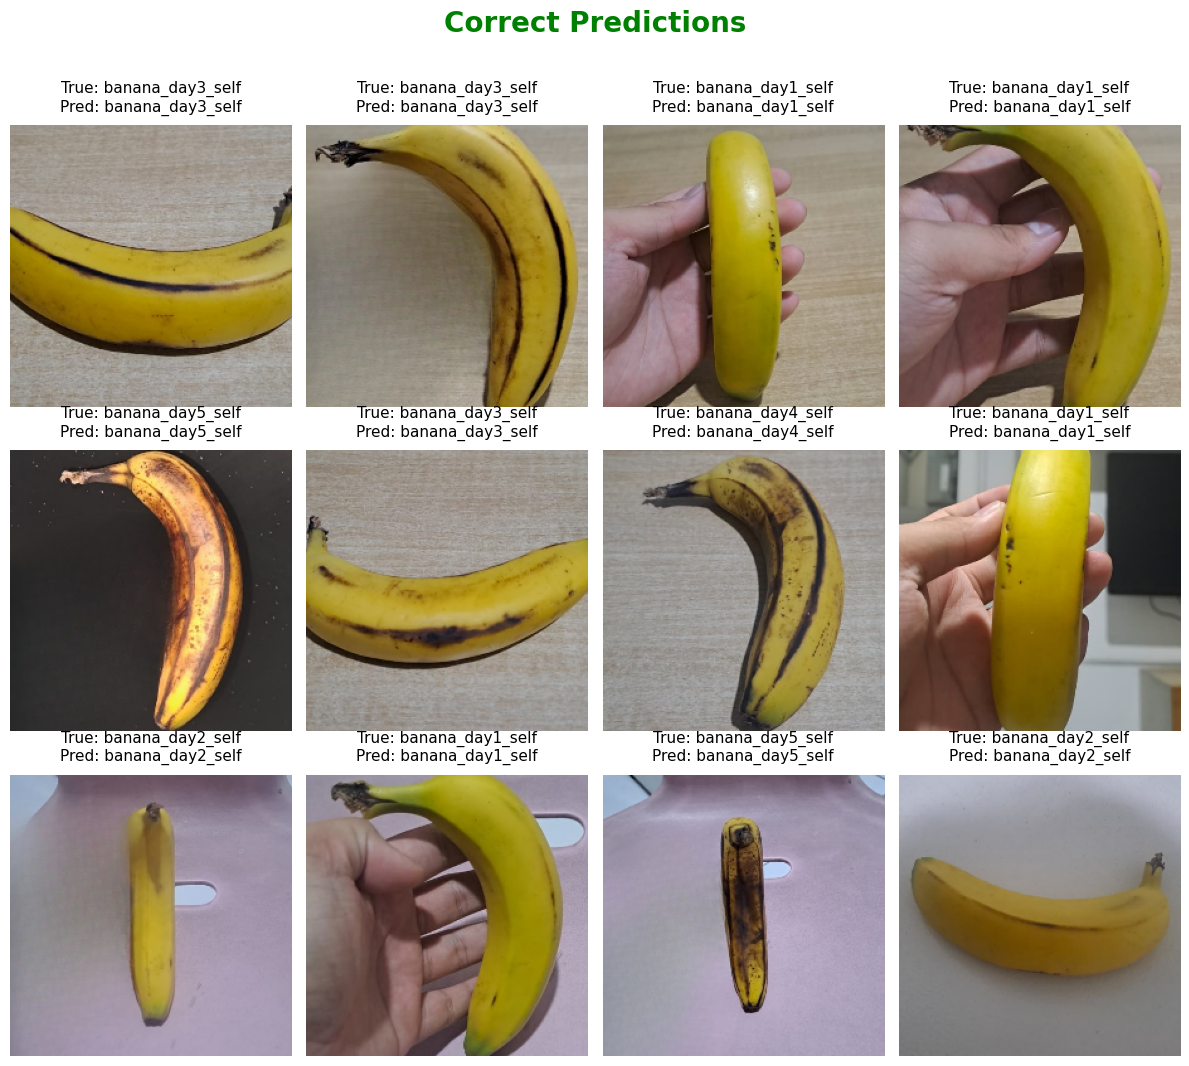

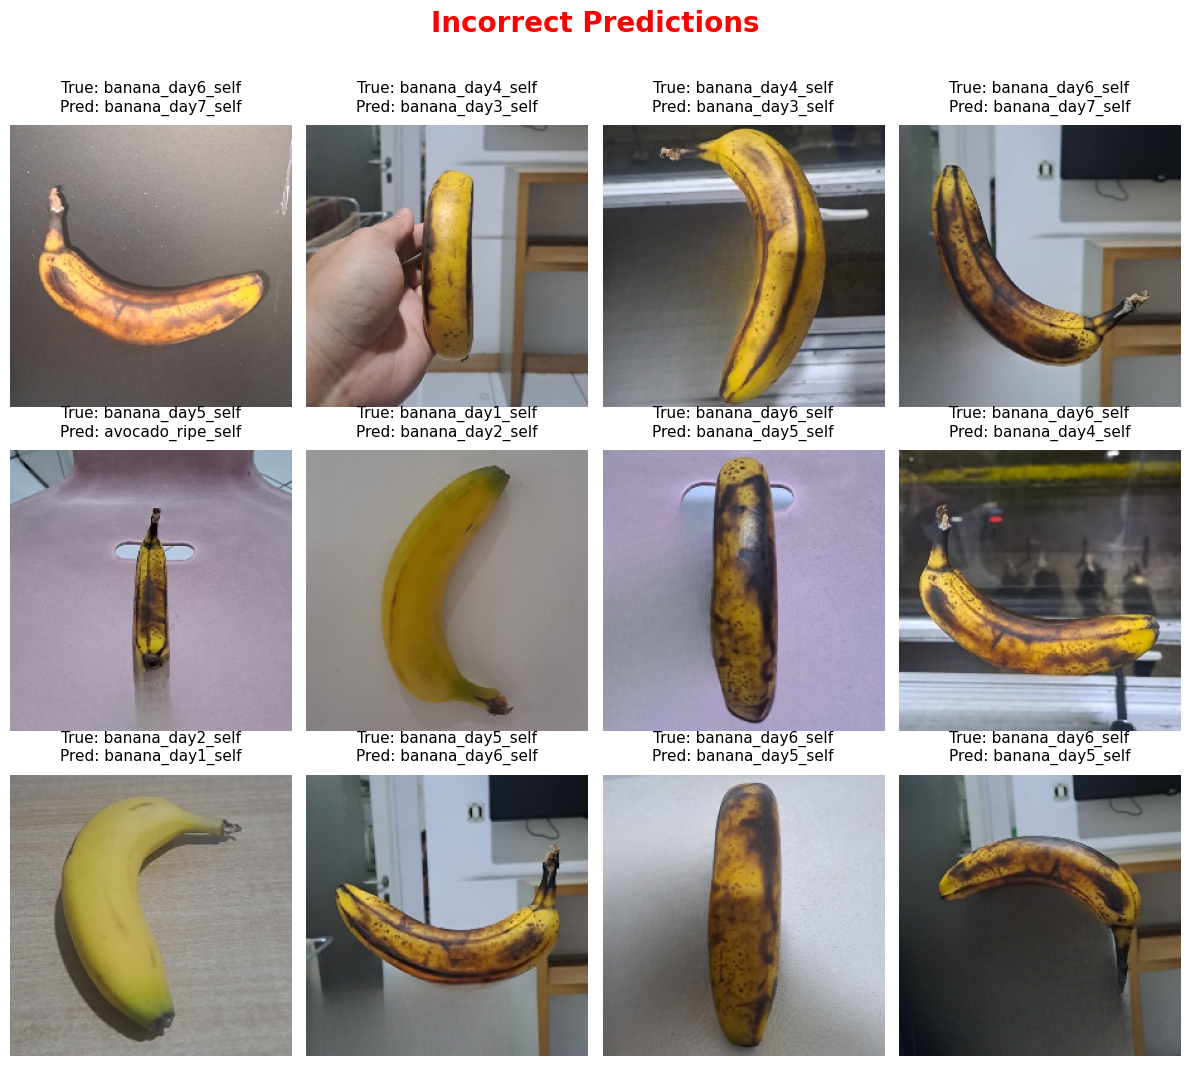

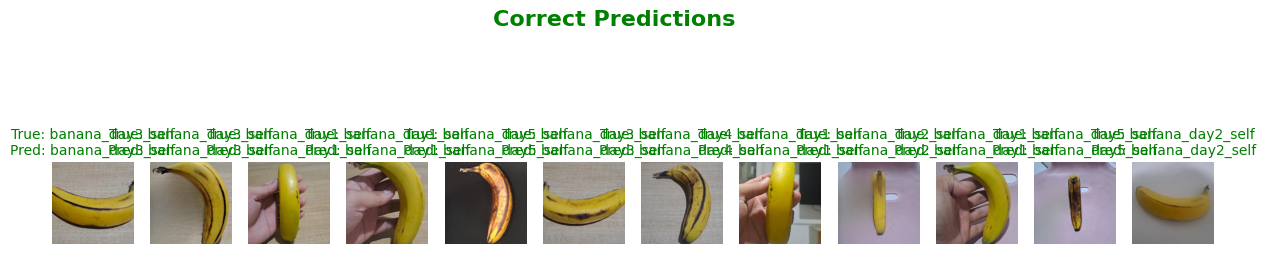

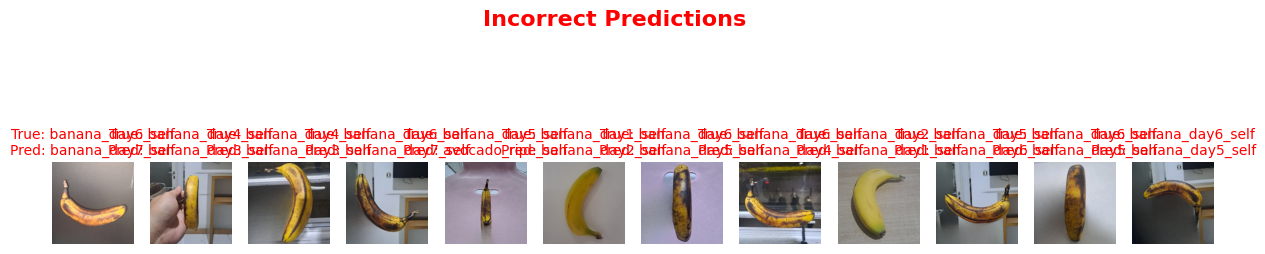

In [ ]:
indexes = final_data_pre.class_name.unique()

# Filter val_df to only banana classes
avocado_val_df = step1aio["val_df"][step1aio["val_df"]["class_name"].str.contains("banana")]

# Build a tf.data.Dataset for banana-only samples (no shuffle/augmentation)
aio_val_ds_avocado = tf.data.Dataset.from_tensor_slices(
    (avocado_val_df["file_path"].values, avocado_val_df["class_name"].values)
)
aio_val_ds_avocado = aio_val_ds_avocado.map(
    lambda x, y: (x, step1aio["label_processor"](y))
)
aio_val_ds_avocado = aio_val_ds_avocado.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
aio_val_ds_avocado = aio_val_ds_avocado.batch(32).prefetch(tf.data.AUTOTUNE)
visualize_predictions(
    aio_val_ds_avocado,
    aio_results["final_model"],
    step1aio["label_processor"],
    grid_rows=3,  # Adjust rows here
    grid_cols=4   # Adjust columns here
)

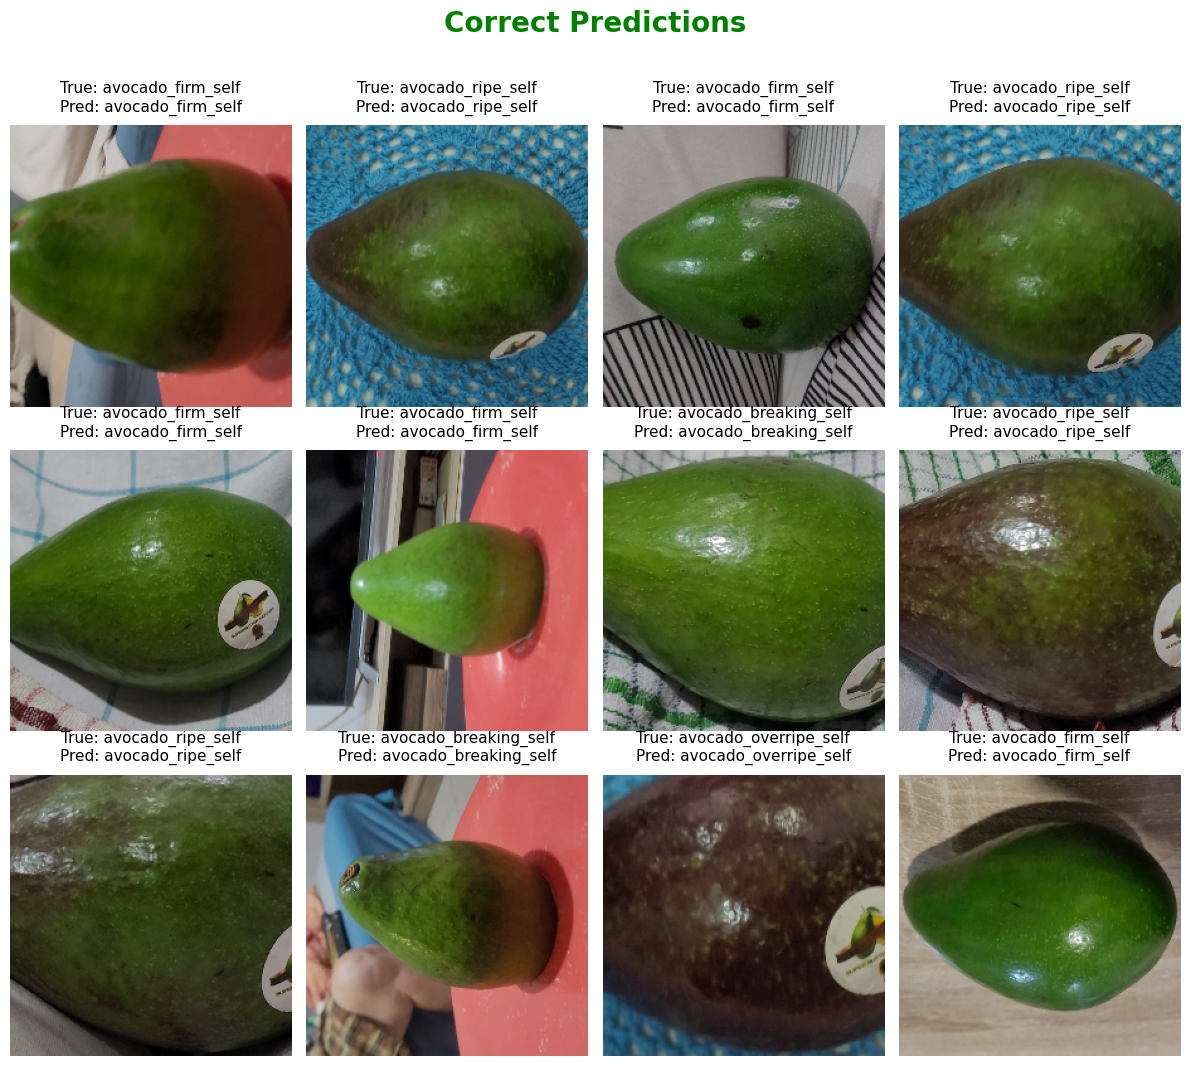

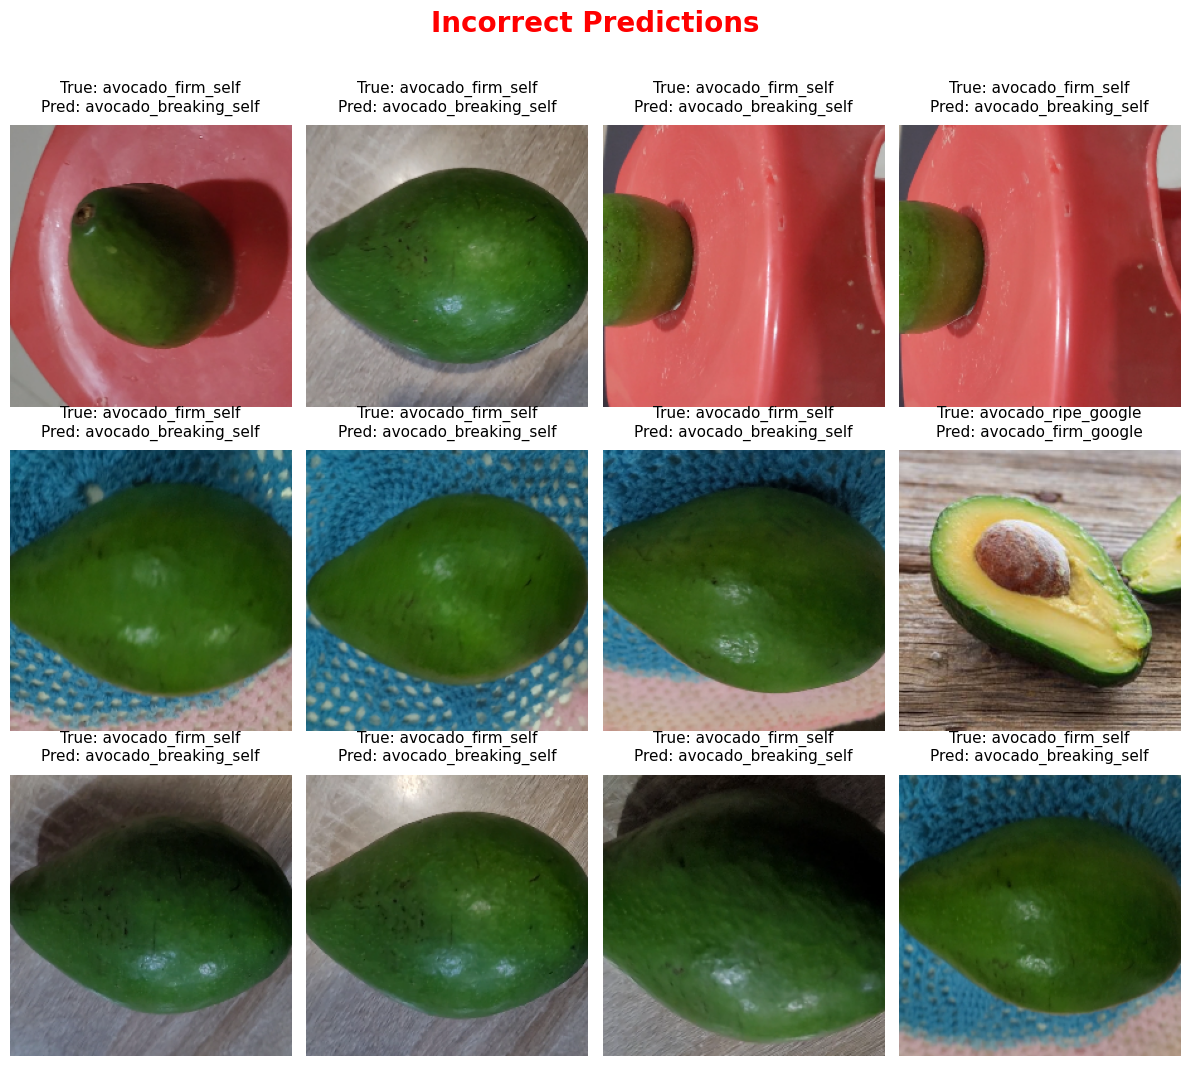

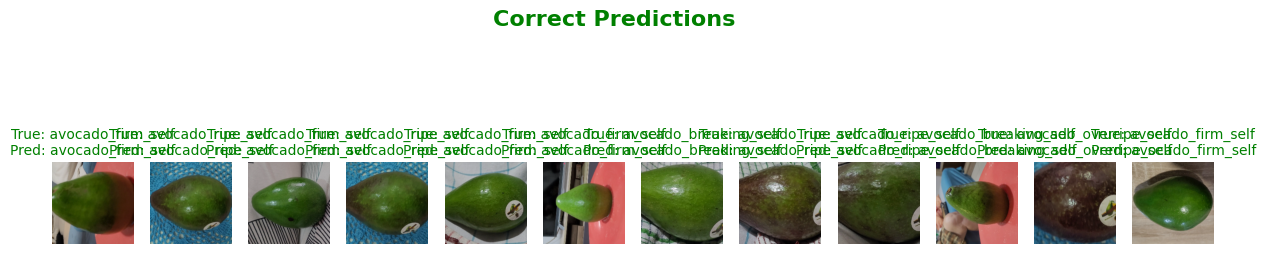

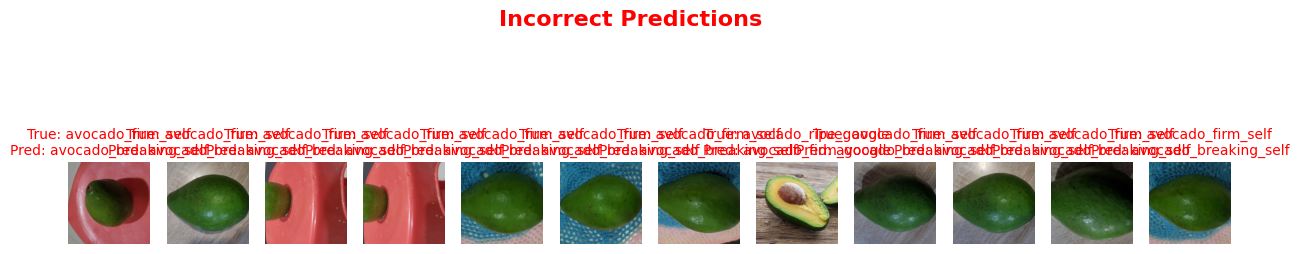

In [19]:
indexes = final_data_pre.class_name.unique()

# Filter val_df to only banana classes
avocado_val_df = step1aio["val_df"][step1aio["val_df"]["class_name"].str.contains("avocado")]

# Build a tf.data.Dataset for banana-only samples (no shuffle/augmentation)
aio_val_ds_avocado = tf.data.Dataset.from_tensor_slices(
    (avocado_val_df["file_path"].values, avocado_val_df["class_name"].values)
)
aio_val_ds_avocado = aio_val_ds_avocado.map(
    lambda x, y: (x, step1aio["label_processor"](y))
)
aio_val_ds_avocado = aio_val_ds_avocado.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
aio_val_ds_avocado = aio_val_ds_avocado.batch(32).prefetch(tf.data.AUTOTUNE)
visualize_predictions(
    aio_val_ds_avocado,
    aio_results["final_model"],
    step1aio["label_processor"],
    grid_rows=3,  # Adjust rows here
    grid_cols=4   # Adjust columns here
)

In [20]:
# ...existing code...

# Build avocado-only eval sets for both models
avocado_val_df = step1aio["val_df"][step1aio["val_df"]["class_name"].str.contains("avocado")]

aio_val_avocado = (
    tf.data.Dataset.from_tensor_slices((avocado_val_df["file_path"].values,
                                        avocado_val_df["class_name"].values))
    .map(lambda x, y: (x, step1aio["label_processor"](y)))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32).prefetch(tf.data.AUTOTUNE)
)

avc_val_avocado = (
    tf.data.Dataset.from_tensor_slices((avocado_val_df["file_path"].values,
                                        avocado_val_df["class_name"].values))
    .map(lambda x, y: (x, step1avc["label_processor"](y)))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32).prefetch(tf.data.AUTOTUNE)
)

# Build banana-only eval sets for both models
banana_val_df = step1aio["val_df"][step1aio["val_df"]["class_name"].str.contains("banana")]

aio_val_banana = (
    tf.data.Dataset.from_tensor_slices((banana_val_df["file_path"].values,
                                        banana_val_df["class_name"].values))
    .map(lambda x, y: (x, step1aio["label_processor"](y)))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32).prefetch(tf.data.AUTOTUNE)
)

ban_val_banana = (
    tf.data.Dataset.from_tensor_slices((banana_val_df["file_path"].values,
                                        banana_val_df["class_name"].values))
    .map(lambda x, y: (x, step1banan["label_processor"](y)))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32).prefetch(tf.data.AUTOTUNE)
)

# Evaluate
print("Avocado subset:")
_, acc_combined_avc = aio_results["final_model"].evaluate(aio_val_avocado, verbose=0)
_, acc_avc_only    = avc_results["final_model"].evaluate(avc_val_avocado, verbose=0)
print(f"  Combined model: {acc_combined_avc*100:.2f}%")
print(f"  Avocado-only  : {acc_avc_only*100:.2f}%")

print("\nBanana subset:")
_, acc_combined_ban = aio_results["final_model"].evaluate(aio_val_banana, verbose=0)
_, acc_ban_only     = banana_results["final_model"].evaluate(ban_val_banana, verbose=0)
print(f"  Combined model: {acc_combined_ban*100:.2f}%")
print(f"  Banana-only   : {acc_ban_only*100:.2f}%")
# ...existing code...

Avocado subset:
  Combined model: 88.91%
  Avocado-only  : 94.46%

Banana subset:


2025-12-19 15:51:17.404237: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1724', 56 bytes spill stores, 56 bytes spill loads

2025-12-19 15:51:17.680847: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1731', 192 bytes spill stores, 192 bytes spill loads



  Combined model: 75.00%
  Banana-only   : 91.07%


### Quantitative Comparison

This analysis provides numerical accuracy comparisons:
- **Avocado Subset**: Combined model vs. Avocado-only model
- **Banana Subset**: Combined model vs. Banana-only model

**Interpretation Guide:**
- If specialized models significantly outperform the combined model (e.g., >5% difference), it suggests maintaining separate models
- If performance is similar, the combined model is preferable for simpler deployment
- Small differences may be within statistical noise—consider running multiple random seeds for robust conclusions

**Practical Implications:**
- **Deployment Simplicity**: One model is easier to maintain, version, and deploy
- **Training Efficiency**: Shared backbone may allow knowledge transfer between fruit types
- **Accuracy Trade-offs**: Slight accuracy losses might be acceptable for operational benefits

In [13]:
banana_results["final_model"].save("banana_only.keras")
avc_results["final_model"].save("avocado_only.keras")

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.resnet50 import preprocess_input

# 1. Get your trained subclassed model
#    (The one that is failing to save)
subclassed_model = aio_results["final_model"]

# 2. Define the new input
#    Ensure this matches your image shape (excluding batch size)
input_shape = (224, 224, 3) 
inputs = layers.Input(shape=input_shape, name="input_image")

# 3. Recreate the "call" logic using the Functional API
#    We use layers.Lambda to wrap raw TensorFlow ops like cast/preprocess
x = layers.Lambda(lambda t: tf.cast(t, tf.float32), name="cast_to_float")(inputs)
x = layers.Lambda(preprocess_input, name="resnet_preprocess")(x)

# 4. Connect the EXISTING backbone
#    We reuse the 'subclassed_model.backbone' object directly. 
#    This keeps the trained weights.
x = subclassed_model.backbone(x)

# 5. Connect the EXISTING dynamic layers
#    We iterate through the lists in your subclass and connect them
for dense_layer, dropout_layer in zip(subclassed_model.dense_layers, subclassed_model.dropout_layers):
    x = dense_layer(x)
    # We can skip the 'training' arg here; the functional model handles it automatically
    x = dropout_layer(x)

# 6. Connect the EXISTING output layer
outputs = subclassed_model.output_layer(x)

# 7. Create the new Functional Model
functional_model = Model(inputs=inputs, outputs=outputs, name="ResNet_Functional_Export")

# 8. Save the Functional Model
#    This is now a standard Keras model, so it saves perfectly without bugs.
save_path = "reconstructed_resnet.keras"
functional_model.save(save_path)

print(f"Success! Converted and saved to {save_path}")

Success! Converted and saved to reconstructed_resnet.keras


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support

def _collect_preds_labels(model, ds):
    y_true, y_pred = [], []
    for images, labels in ds:
        logits = model(images, training=False)
        preds = tf.argmax(logits, axis=1)
        y_true.extend(labels.numpy().tolist())
        y_pred.extend(preds.numpy().tolist())
    return y_true, y_pred

def evaluate_model_quantitatively(model_name, model, val_ds, label_processor):
    class_names = label_processor.get_vocabulary()
    num_classes = len(class_names)

    y_true, y_pred = _collect_preds_labels(model, val_ds)

    # F1 per model (macro and weighted)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    print(f"\n=== {model_name} ===")
    print(f"F1 (macro):   {f1_macro:.4f}")
    print(f"F1 (weighted):{f1_weighted:.4f}")

    # Confusion matrix per model
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    print("Confusion Matrix (rows=true, cols=pred):")
    print(cm)

    # Optional visualization (requires matplotlib already imported earlier)
    fig, ax = plt.subplots(figsize=(0.9 * num_classes + 3, 0.9 * num_classes + 3))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(f"{model_name} - Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(range(num_classes))
    ax.set_yticks(range(num_classes))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_yticklabels(class_names)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # Annotate cells
    for i in range(num_classes):
        for j in range(num_classes):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=9)
    plt.tight_layout()
    plt.show()

    # Precision and recall per class
    precision, recall, _, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=list(range(num_classes)), zero_division=0
    )
    print("Per-class Precision / Recall:")
    for idx, name in enumerate(class_names):
        print(f"  {name:20s}  Precision: {precision[idx]:.4f}  Recall: {recall[idx]:.4f}")

    return {
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "confusion_matrix": cm,
        "per_class_precision": dict(zip(class_names, precision)),
        "per_class_recall": dict(zip(class_names, recall)),
    }

# Run quantitative evaluation for each model on its validation set
metrics_avocado = evaluate_model_quantitatively(
    "Avocado-Only",
    avc_results["final_model"],
    step2avc["val_ds"],
    step1avc["label_processor"]
)

metrics_banana = evaluate_model_quantitatively(
    "Banana-Only",
    banana_results["final_model"],
    step2banan["val_ds"],
    step1banan["label_processor"]
)

metrics_all_in_one = evaluate_model_quantitatively(
    "All-in-One",
    aio_results["final_model"],
    step2aio["val_ds"],
    step1aio["label_processor"]
)

### Metodologi

Model dikembangkan menggunakan TensorFlow dengan arsitektur pipeline terintegrasi, di mana proses ekstraksi fitur dan klasifikasi berada dalam satu grafik komputasi. Sebagai backbone, digunakan ResNet50 yang telah dipra-latih, sehingga model dapat memanfaatkan fitur visual tingkat tinggi tanpa harus dilatih dari nol. Lapisan akhir kemudian disesuaikan untuk tugas klasifikasi kematangan buah.

### Strategi Pelatihan

Dataset dibagi menjadi tiga bagian untuk memastikan evaluasi yang adil dan menghindari kebocoran data:

- 68% data pelatihan untuk melatih bobot model

- 17% data pengujian untuk optimasi hyperparameter menggunakan Optuna

- 15% data validasi sebagai held-out set untuk evaluasi akhir

Selama pelatihan, diterapkan augmentasi data secara on-the-fly, seperti rotasi, flip, zoom, translasi, serta penyesuaian kontras dan kecerahan. Strategi ini bertujuan untuk meningkatkan kemampuan generalisasi model terhadap variasi data nyata.

### Eksperimen Model

Tiga jenis model dilatih dan dibandingkan:

- Model khusus alpukat

- Model khusus pisang

- Model terpadu (combined) yang menangani kedua jenis buah sekaligus

### Hasil evaluasi menunjukkan bahwa:

- Model spesialis memberikan akurasi sedikit lebih tinggi pada domain yang sangat spesifik

- Model terpadu tetap menunjukkan performa yang kompetitif pada kedua jenis buah

- Model terpadu lebih unggul dari sisi kemudahan deployment dan efisiensi sistem

### Optimasi Hyperparameter

Untuk meningkatkan performa model, digunakan Optuna dengan pendekatan TPE, yang secara otomatis mencari kombinasi terbaik dari learning rate, jumlah layer, jumlah unit, dropout, dan jumlah epoch. Pendekatan ini terbukti lebih efisien dibandingkan manual tuning.

### Kesimpulan

Dari eksperimen yang dilakukan, dapat disimpulkan bahwa:

- Pendekatan transfer learning dengan ResNet50 efektif untuk klasifikasi kematangan buah

- Pipeline terintegrasi lebih efisien dan praktis untuk aplikasi produksi

- Terdapat trade-off antara akurasi maksimal dan kompleksitas sistem

- Model terpadu merupakan pilihan terbaik untuk sistem nyata dengan keterbatasan resource
